Columns kept after dropping those with >50% missing values:
['bedrooms', 'gla', 'pool', 'condition', 'propertyType']
Missing values per column after imputation:
bedrooms        0
gla             0
pool            0
condition       0
propertyType    0
dtype: int64


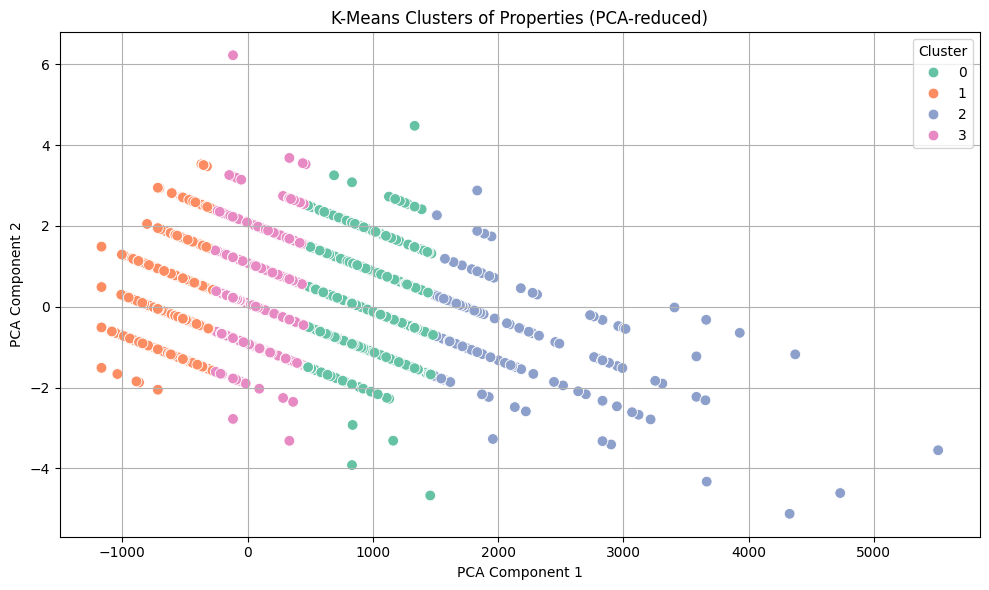

In [9]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_json('appraisals_dataset.json')
appraisals = df.iloc[:, 0].tolist()

# Normalize address helper
def normalize_address(addr):
    if not addr:
        return ""
    addr = addr.lower().strip()
    addr = re.sub(r'\bst\b', 'street', addr)
    addr = re.sub(r'\bave\b', 'avenue', addr)
    addr = re.sub(r'\brd\b', 'road', addr)
    addr = re.sub(r'\bdr\b', 'drive', addr)
    addr = re.sub(r'[^\w\s]', '', addr)
    addr = re.sub(r'\s+', ' ', addr)
    return addr

# Encoders
condition_map = {"poor": 1, "fair": 2, "average": 3, "good": 4, "excellent": 5}
property_type_map = {}

def encode_property_type(ptype):
    if not ptype:
        return 0
    ptype = ptype.lower()
    if ptype not in property_type_map:
        property_type_map[ptype] = len(property_type_map) + 1
    return property_type_map[ptype]

def safe_float(val):
    try:
        return float(val)
    except (TypeError, ValueError):
        return np.nan

def extract_features(prop):
    return [
        safe_float(prop.get("bedrooms")),
        safe_float(prop.get("full_bath")) + 0.5 * safe_float(prop.get("half_bath")),
        safe_float(prop.get("gla")),
        safe_float(prop.get("yearBuilt")),
        safe_float(prop.get("lotSize")),
        safe_float(prop.get("garageSpaces")),
        1.0 if str(prop.get("pool", "")).lower() in ["yes", "true", "1"] else 0.0,
        condition_map.get(str(prop.get("condition", "")).lower(), 0),
        encode_property_type(prop.get("propertyType")),
        safe_float(prop.get("zipCode")),
    ]

# Flatten all properties
property_records = []
for appraisal in appraisals:
    for prop in appraisal.get("properties", []):
        property_records.append(extract_features(prop))

X = pd.DataFrame(property_records, columns=[
    "bedrooms", "bathrooms", "gla", "yearBuilt", "lotSize",
    "garageSpaces", "pool", "condition", "propertyType", "zipCode"
])

# Convert to numeric (just in case)
X = X.apply(pd.to_numeric, errors='coerce')

# Drop columns with more than 50% missing values
threshold = 0.5
missing_ratio = X.isna().mean()
cols_to_keep = missing_ratio[missing_ratio <= threshold].index
X = X[cols_to_keep]

print("Columns kept after dropping those with >50% missing values:")
print(cols_to_keep.tolist())

# Impute missing values with median
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Missing values per column after imputation:")
print(X_imputed.isna().sum())

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
X_imputed["cluster"] = kmeans.fit_predict(X_imputed)

# PCA for visualization (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed.drop(columns=["cluster"]))

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_imputed["cluster"], palette="Set2", s=60)
plt.title("K-Means Clusters of Properties (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


[[2886    5]
 [  55    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2891
           1       0.00      0.00      0.00        55

    accuracy                           0.98      2946
   macro avg       0.49      0.50      0.49      2946
weighted avg       0.96      0.98      0.97      2946



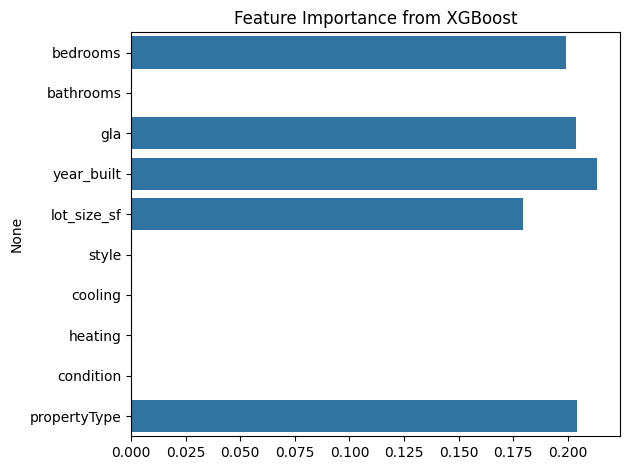


---- Top 3 Predicted Comps per Appraisal ----

Order ID: 4762597
Predicted top 3 comps:
 - 605 Truedell Rd
 - 792 Safari Dr
 - 667 Truedell Rd
Correct predictions: 0 / 3

Order ID: 4762739
Predicted top 3 comps:
 - 9051 Highway 7
 - 46 Ostrea Lake Road
 - 215 Scotsdale Drive
Correct predictions: 0 / 3

Order ID: 4763065
Predicted top 3 comps:
 - 13 Shedrow Place
 - 3219 Roseville Road
 - 2259 Cedar Creek Road
Correct predictions: 1 / 3

Order ID: 4763086
Predicted top 3 comps:
 - 56 Stonewalk Drive
 - 56 Stonewalk Dr
 - 1157 COUNTY 18 Rd
Correct predictions: 2 / 3

Order ID: 4763087
Predicted top 3 comps:
 - 75 Forestside Crescent
 - 92 Forestside Crescent
 - Unit 801 105 Dunbrack Street
Correct predictions: 1 / 3

Order ID: 4764094
Predicted top 3 comps:
 - 123 Crestwood Place
 - 64 Bellroyal Court
 - 57 Caldwell Road
Correct predictions: 1 / 3

Order ID: 4764103
Predicted top 3 comps:
 - 82 McRae Drive
 - Unit 1023 - 35 Brian Peck Crescent
 - Unit 113 - 21 Burkebrook Place
Correct p

In [10]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
df = pd.read_json("appraisals_dataset.json")
appraisals = df.iloc[:, 0].tolist()

# Helper functions
def safe_float(val):
    if str(val).lower() in ["", "none", "null", "na", "n/a", "nan"]:
        return np.nan
    try:
        return float(val)
    except (TypeError, ValueError):
        return np.nan

condition_map = {"poor": 1, "fair": 2, "average": 3, "good": 4, "excellent": 5}
property_type_map = {}

def encode_property_type(ptype):
    if not ptype or str(ptype).strip().lower() in ["", "none", "null", "nan"]:
        return np.nan
    ptype = ptype.lower()
    if ptype not in property_type_map:
        property_type_map[ptype] = len(property_type_map) + 1
    return property_type_map[ptype]

def compute_address_similarity(address1, comp_addresses, threshold=0.50):
    if not address1 or not comp_addresses:
        return 0
    all_addresses = [address1] + list(comp_addresses)
    tfidf = TfidfVectorizer().fit_transform(all_addresses)
    sim_matrix = cosine_similarity(tfidf[0:1], tfidf[1:])
    max_sim = np.max(sim_matrix)
    return max_sim >= threshold

def extract_features(prop):
    return [
        safe_float(prop.get("bedrooms")),
        safe_float(prop.get("full_bath")) + 0.5 * safe_float(prop.get("half_bath")),
        safe_float(prop.get("gla")),
        safe_float(prop.get("year_built")),
        safe_float(prop.get("lot_size_sf")),
        safe_float(prop.get("style")),
        safe_float(prop.get("cooling")),
        safe_float(prop.get("heating")),
        condition_map.get(str(prop.get("condition", "")).lower(), np.nan),
        encode_property_type(prop.get("structure_type")),
    ]

# Build labeled dataset
records = []
for appraisal in appraisals:
    comps = appraisal.get("comps", [])
    comp_addresses = {c.get("address", "").strip() for c in comps if c.get("address")}
    for prop in appraisal.get("properties", []):
        address = prop.get("address", "").strip()
        is_comp = 1 if address in comp_addresses or compute_address_similarity(address, comp_addresses) else 0
        features = extract_features(prop)
        records.append(features + [address, is_comp])

# Create DataFrame
columns = [
    "bedrooms", "bathrooms", "gla", "year_built", "lot_size_sf",
    "style", "cooling", "heating", "condition", "propertyType", "address", "is_comp"
]
df_props = pd.DataFrame(records, columns=columns)

# Prepare data
X = df_props.drop(columns=["is_comp", "address"])
y = df_props["is_comp"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train XGBoost
model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Feature Importance from XGBoost")
plt.tight_layout()
plt.show()

# 🔍 Predict Top 3 Comps per Appraisal
print("\n---- Top 3 Predicted Comps per Appraisal ----")
total_correct = 0
total_possible = 0

for i, appraisal in enumerate(appraisals):
    props = appraisal.get("properties", [])
    features = [extract_features(p) for p in props]
    prop_addresses = [p.get("address", "").strip() for p in props]
    X_props = pd.DataFrame(features, columns=X.columns)

    if X_props.empty:
        continue

    probas = model.predict_proba(X_props)[:, 1]
    top_indices = np.argsort(probas)[-3:][::-1]
    predicted_top3 = [prop_addresses[i] for i in top_indices]

    true_comps = {c.get("address", "").strip() for c in appraisal.get("comps", []) if c.get("address")}
    correct = sum(
        addr in true_comps or compute_address_similarity(addr, true_comps)
        for addr in predicted_top3
    )
    total_correct += correct
    total_possible += len(true_comps)

    print(f"\nOrder ID: {appraisal.get('orderID')}")
    print("Predicted top 3 comps:")
    for addr in predicted_top3:
        print(f" - {addr}")
    print(f"Correct predictions: {correct} / 3")

# Final metrics
precision_at_3 = total_correct / (len(appraisals) * 3)
recall = total_correct / total_possible if total_possible else 0

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nOverall Precision@3: {precision_at_3:.4f}")
print(f"Overall Recall@3: {recall:.4f}")


In [1]:
pip install openai==0.28